In [18]:
 import warnings
 warnings.filterwarnings('ignore')

In [19]:
import numpy as np
import pandas as pd 
import matplotlib as plt
file = "2010 Federal STEM Education Inventory Data Set.xls"
x1=pd.ExcelFile(file)
df2=x1.parse(0,skiprows=[0],nrows= 252,index_col="Index Number")
df2.drop(["B) Year Established"], axis=1,inplace=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000205CDE4BCC0>,
      dtype=object)

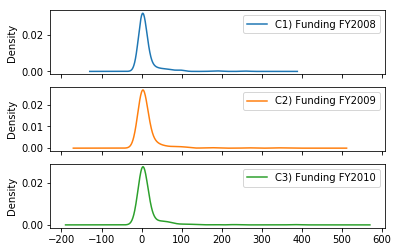

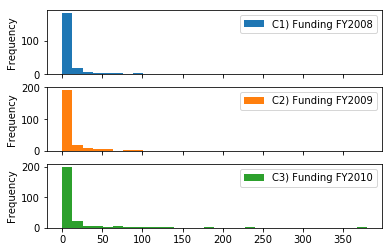

In [29]:
%matplotlib inline
LABELS=["C1) Funding FY2008","C2) Funding FY2009","C3) Funding FY2010"]
import matplotlib as plt
df2[LABELS].plot(kind="kde",subplots=True)
df2[LABELS].plot(kind="hist",bins=30,subplots=True)

In [ ]:
import sklearn
from sklearn.preprocessing  import Imputer
imp = Imputer(missing_values="NaN",strategy="median",axis=0)
imp.fit(df2[LABELS])
df2[LABELS]=imp.transform(df2[LABELS])

In [6]:
#Target Variable
df2['+ve%growth'] = np.where(((df2["C2) Funding FY2009"]-df2["C1) Funding FY2008"])/df2["C1) Funding FY2008"]*100>0), 1, 0)

In [ ]:
#from IPython.core.display import HTML
#display(HTML(df2.to_html()))

In [7]:
#basic_model_with_only_numerical_columns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve
numeric_data_only=df2[LABELS]
X_train, X_test, y_train, y_test = train_test_split(df2[LABELS], df2['+ve%growth'], test_size = 0.30, random_state=42, stratify=df2['+ve%growth'])
clf=(LogisticRegression())
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
print("ROC_AUC: {}".format(roc_auc_score(y_test,y_pred)))

ROC_AUC: 0.8548387096774194


In [8]:
df1=df2.loc[:, pd.notnull(df2).sum()>=len(df2)*.20]
#df1.info()

In [9]:
NUMERIC_COLUMNS =[ "C1) Funding FY2008","C2) Funding FY2009","C3) Funding FY2010","+ve%growth"]
NUMERIC_COLUMNS_T= [ "C1) Funding FY2008","C2) Funding FY2009","C3) Funding FY2010"]
NUMERIC_COLUMNS_S = ["C3) Funding FY2010"]

In [16]:
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS_S):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop,axis=1)
    
    # Replace nans with blanks
    text_data.fillna("",inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [47]:
from sklearn.preprocessing import FunctionTransformer,MaxAbsScaler
get_text_data = FunctionTransformer(combine_text_columns,validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS_S], validate=False)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1.drop(['+ve%growth','C1) Funding FY2008','C2) Funding FY2009'],axis=1), df1['+ve%growth'], test_size = 0.30, random_state=42, stratify=df1['+ve%growth'])

#Check CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'
TOKENS_BASIC = '\\S+(?=\\s+)'
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(X_train)
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))


There are 2752 alpha-numeric tokens in the dataset


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
chi_k=250
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ("selector", get_numeric_data),
            ])),
                ('text_features', Pipeline([
                    ("selector",get_text_data),
                    ("vectorizer", HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,non_negative=True, norm=None, binary=False, ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ])), ("clf",LogisticRegression())
        ])


In [18]:
pl.fit(X_train,y_train)
y_pred=pl.predict(X_test)
print("ROC_AUC: {}".format(roc_auc_score(y_test,y_pred)))

ROC_AUC: 0.5340501792114695


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {"clf__C": c_space,"clf__penalty": ['l1', 'l2']}

#logreg_cv = GridSearchCV(pl,param_grid,cv=5)
logreg_cv= RandomizedSearchCV(pl,param_grid, cv=5)

In [34]:
logreg_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x0000026390CA1D08>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'clf__C': array([1.00000e-05, 8.48343e-05, 7.19686e-04, 6.10540e-03, 5.17947e-02,
       4.39397e-01, 3.72759e+00, 3.16228e+01, 2.68270e+02, 2.27585e+03,
       1.93070e+04, 1.63789e+05, 1.38950e+06, 1.17877e+07, 1.00000e+08]), 'clf__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [28]:
print("Tuned Logistic Regression: {}".format(logreg_cv.best_params_))

Tuned Logistic Regression: {'clf__C': 0.006105402296585327, 'clf__penalty': 'l2'}


In [32]:
y_pred_RS = logreg_cv.predict(X_test)

In [33]:
print("ROC_AUC: {}".format(roc_auc_score(y_test,y_pred_RS)))

ROC_AUC: 0.5412186379928315


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
chi_k=250
plxgb = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ("selector", get_numeric_data),
            ])),
                ('text_features', Pipeline([
                    ("selector",get_text_data),
                    ("vectorizer", HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,non_negative=True, norm=None, binary=False, ngram_range=(1,2)))]))
             ])),("scale",MaxAbsScaler()),("clf",xgb.XGBClassifier())
        ])


In [42]:
plxgb.fit(X_train,y_train)
y_pred_xgb=plxgb.predict(X_test)
print("ROC_AUC: {}".format(roc_auc_score(y_test,y_pred_xgb)))

ROC_AUC: 0.5602150537634409


In [43]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
# Create the hyperparameter grid
gbm_grid = {"clf__subsample": np.arange(0.5,1,0.05),"clf__max_depth": np.arange(3,20,1),"clf__colsample_bytree":np.arange(.1,1.05,0.05)}
# Instantiate the GridSearchCV object: logreg_cv
xgboost_cv= RandomizedSearchCV(plxgb,gbm_grid, cv=5)

In [44]:
xgboost_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001B4B8664EA0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'clf__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'clf__subsample': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]), 'clf__colsample_bytree': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
        

In [46]:
print("Tuned XGBoost: {}".format(xgboost_cv.best_params_))
y_pred_xgb_RS = xgboost_cv.predict(X_test)
print("ROC_AUC: {}".format(roc_auc_score(y_test,y_pred_xgb_RS)))

Tuned XGBoost: {'clf__max_depth': 5, 'clf__subsample': 0.5, 'clf__colsample_bytree': 0.3500000000000001}
ROC_AUC: 0.599641577060932
